# Binary classification
---------------------------------

Download the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).
 This dataset tries to predict whether or not it will rain tomorrow by
 training a classification model on target `RainTomorrow`.

### Load the data

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier

# Load the Australian weather dataset
X = pd.read_csv('../weatherAUS.csv')
X = X.drop(['RISK_MM', 'Date'], axis=1)  # Drop unrelated features

In [2]:
# Let's have a look at the dataset
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Run the pipeline

In [3]:
# Call ATOM using only a percentage of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, y="RainTomorrow", percentage=5, log='auto', n_jobs=2, verbose=3)

<<=============== ATOM ===============>>
Parallel processing with 2 cores.
Initial data cleaning...
Algorithm task: binary classification.

Dataset stats ===================>
Shape: (7110, 22)
Missing values: 15836
Categorical columns: 5
Scaled: False
----------------------------------
Size of training set: 4977
Size of test set: 2133
----------------------------------
Class balance: No:Yes <==> 3.6:1.0
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     5562 |         3896 |        1666 |
| 1: Yes |     1548 |         1081 |         467 |



In [4]:
# If we change a column during the pre-processing,
# we need to call the update method to update all data attributes

atom.X['MaxTemp'] = np.log(atom.X['MaxTemp'])  # Random operator on column MaxTemp

# MaxTemp has now been changed for atom.X, but not in atom.X_train, atom.dataset, etc...
# To do so, we use the update method, where the parameter is a string of the changed attribute
atom.update('X')

assert atom.X['MaxTemp'].equals(atom.dataset['MaxTemp'])

In [5]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)

Imputing missing values...
 --> Removing 736 rows for containing too many missing values.
 --> Imputing 10 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 2 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 35 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2365 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2666 missing values using the KNN imputer in feature Sunshine.
 --> Removing 224 rows due to missing values in feature WindGustDir.
 --> Imputing 223 missing values using the KNN imputer in feature WindGustSpeed.
 --> Removing 327 rows due to missing values in feature WindDir9am.
 --> Removing 26 rows due to missing values in feature WindDir3pm.
 --> Imputing 4 missing values using the KNN imputer in feature WindSpeed9am.
 --> Imputing 5 missing values using the KNN imputer in feature WindSpeed3pm.
 --> Imputing 25 missing values using the KNN imputer in feature Humidity9am.
 --> Imputin

In [6]:
# Encode the categorical features
atom.encode(max_onehot=10, frac_to_other=0.04)

Encoding categorical features...
 --> Target-encoding feature Location.  Contains 1 unique categories.
 --> Target-encoding feature WindGustDir.  Contains 16 unique categories.
 --> Target-encoding feature WindDir9am.  Contains 16 unique categories.
 --> Target-encoding feature WindDir3pm.  Contains 16 unique categories.
 --> Label-encoding feature RainToday. Contains 2 unique categories.


In [7]:
# Perform undersampling of the majority class to balance the dataset
atom.balance(undersample=0.8)

Performing undersampling...
 --> Removing 239 rows from class No.


Using TensorFlow backend.


In [8]:
# Remove outliers from the training set
atom.outliers(max_sigma=5)

Handling outliers...
 --> Dropping 22 rows due to outliers.


In [9]:
# Select only the best 10 features
atom.feature_selection(strategy="univariate", max_features=15, max_correlation=0.8)

# See which features were removed due to collinearity
atom.collinear

Performing feature selection...
 --> Feature Pressure3pm was removed due to collinearity with another feature.
 --> Feature Temp9am was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.


,drop_feature,correlated_feature,correlation_value
0,Pressure3pm,Pressure9am,0.95258
1,Temp9am,"MinTemp, MaxTemp","0.93135, 0.89859"
2,Temp3pm,"MaxTemp, Temp9am","0.95784, 0.88146"


In [10]:
# Change the verbosity of ATOM to not print too much details while fitting
atom.verbose = 2

# Define a custom metric
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# We can compare the performance of various gradient boosting algorithms
atom.pipeline(['gbm', 'lgb', 'catb'],
              metric=f2_score,
              max_iter=5,
              init_points=5,
              cv=1,
              bagging=5)


Running pipeline =================>
Models in pipeline: GBM, LGB, CatB
Metric: f2_score


Running BO for Gradient Boosting Machine...
Final results for Gradient Boosting Machine:         
Bayesian Optimization ---------------------------
Best hyperparameters: {'n_estimators': 249, 'learning_rate': 1.0, 'subsample': 0.7, 'max_depth': 2, 'max_features': 0.6, 'criterion': 'friedman_mse', 'min_samples_split': 20, 'min_samples_leaf': 11, 'ccp_alpha': 0.02}
Best score on the BO: 0.7684
Time elapsed: 6.856s
Fitting -----------------------------------------
Score on the training set: 0.7305
Score on the test set: 0.6330
Time elapsed: 0.491s
Bagging -----------------------------------------
Mean: 0.6086   Std: 0.0269
Time elapsed: 2.117s
-------------------------------------------------
Total time: 9.469s


Running BO for LightGBM...
Final results for LightGBM:         
Bayesian Optimization ---------------------------
Best hyperparameters: {'n_estimators': 361, 'learning_rate': 0.8, 'max_dept

### Analyze the results

In [11]:
# Let's have a look at the best model
print('And the winner is...', atom.winner.longname)

# The ~ symbol indicates that the model is probably overfitting the training set
# This happens because we only use 5% of the dataset
# We can see that the training score is >20% of the test score
print('Score on the training set: ', atom.winner.score_train)
print('Score on the test set: ', atom.winner.score_test)

And the winner is... LightGBM
Score on the training set:  0.7702407002188184
Score on the test set:  0.6830769230769231


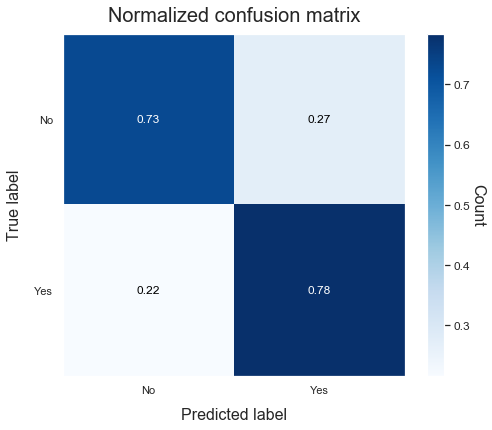

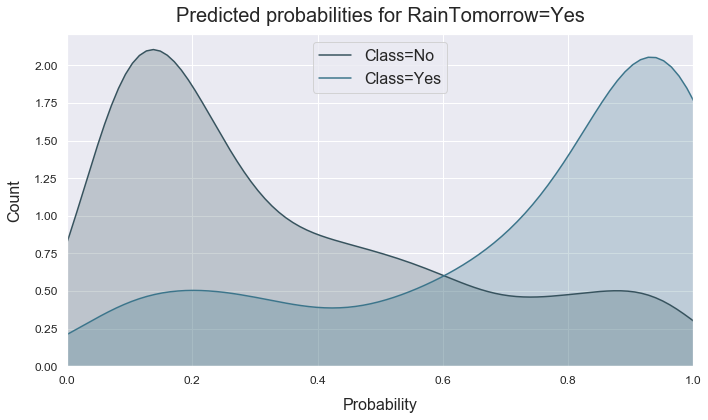

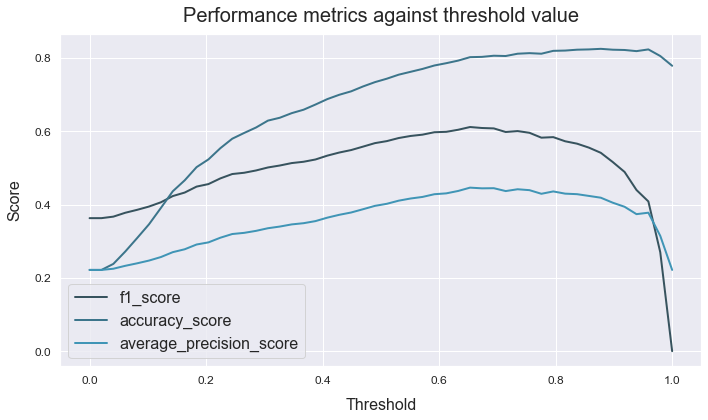

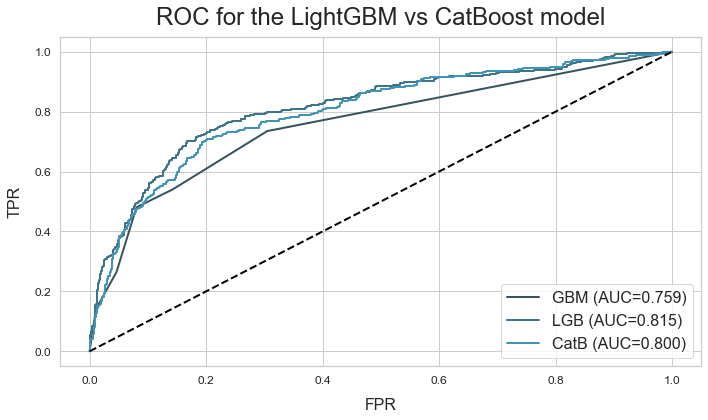

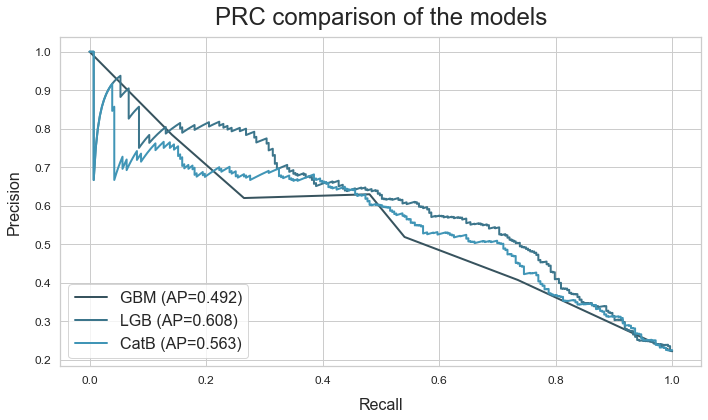

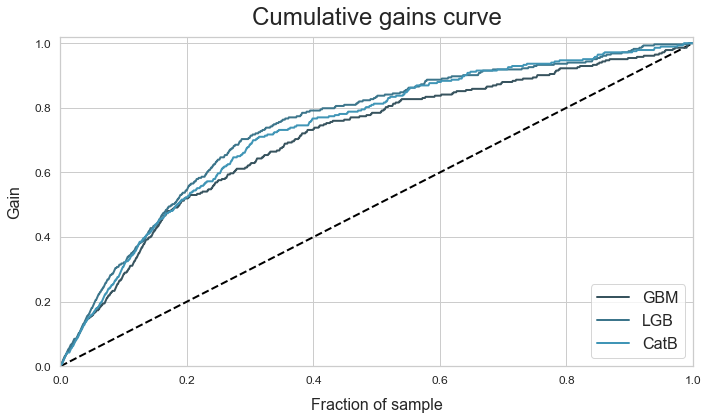

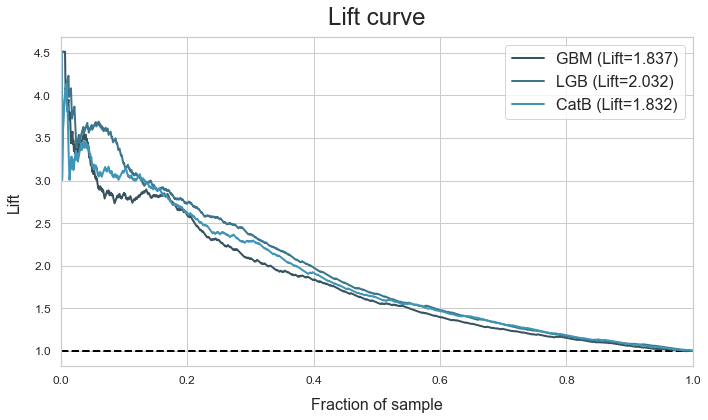

In [12]:
# Check the winner's confusion matrix and probability distribution
atom.winner.plot_confusion_matrix(normalize=True, figsize=(7, 7), filename='confusion_matrix.png')
atom.winner.plot_probabilities()

# How do other metrics perform for different thresholds on the winning model
atom.winner.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')

# Change plots aesthetics
ATOMClassifier.set_style('whitegrid')
ATOMClassifier.set_title_fontsize(24)

# Make some plots to compare the models
atom.plot_ROC(title="ROC for the LightGBM vs CatBoost model")
atom.plot_PRC(title="PRC comparison of the models")